In [124]:
import sys
sys.path.append('../lib/BioInfer_software_1.0.1_Python3/')
sys.path.append('../py/')
from BIParser import BIParser

import os
import json
os.environ['DGL_BACKEND'] = "pytorch" 
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import dgl
import torch as th
import torch.nn as nn

from collections import OrderedDict

In [2]:
parser = BIParser()

In [3]:
with open('../data/BioInfer_corpus_1.1.1.xml','r') as f:
    parser.parse(f)

Experimentation with DGL, can ignore:

In [4]:
# graph_data = {
#    ('drug', 'interacts', 'drug'): (th.tensor([0, 1]), th.tensor([1, 2])),
#    ('drug', 'interacts', 'gene'): (th.tensor([0, 1]), th.tensor([2, 3])),
#    ('drug', 'treats', 'disease'): (th.tensor([1]), th.tensor([2]))
# }

# graph = dgl.heterograph(graph_data)

# create graph for each example
# types of edges are

# graph_data = {
#    ('drug', 'INHIBITS', 'gene'): (th.tensor([0, 1]), th.tensor([1, 2])),
#    ('drug', 'PROMOTES', 'gene'): (th.tensor([0, 1]), th.tensor([2, 3])),
#    ('gene', 'PROMOTES', 'gene'): (th.tensor([1]), th.tensor([2]))
# }

# graph

#### Extract relevant info from parsed BioInfer data

In [5]:
texts = []
BIO_labels = []
tuple_labels = []


sentences = parser.bioinfer.sentences.sentences
for s in sentences:
    tokens = [t.getText() for t in s.tokens]
    
    # initialize Beginning Inside Outside (BIO) encoding for entities, maybe useful if we want to add NER as joint task
    NER_labels = ['O' for t in s.tokens] 
    
    # GET DISJOINT SETS OF NESTED AND TOP-LEVEL ENTITIES
    #  - I don't think there is an e.isNested() type of 
    # method so this is how I ended up checking
    nested_entities = set()
    for e in s.entities:
        for n in e.nestedEntities:
            nested_entities.add(n)

    top_level_entities = set()
    for e in s.entities:
        if e not in nested_entities:
            top_level_entities.add(e)
    
    #check that sets are disjoint and cover the full set of entities in the sentence
    disjoint = len(nested_entities.intersection(top_level_entities)) == 0
    matching_len = len(nested_entities) + len(top_level_entities) == len(s.entities)
    assert disjoint and matching_len
    
    
    
    # CREATE TUPLES OF (<entity_class>, (<entity_token_1>,<entity_token_2>,...)
    # note that this ignores labels starting with "RELATIONSHIP_"
    entity_tuples = []
    
    for e in nested_entities:
        entity_type = e.type.name
        if 'RELATIONSHIP' not in entity_type:
            entity_tuples.append((entity_type,tuple([st.token.sequence for st in e.subTokens])))
            
    for e in top_level_entities:
        entity_type = e.type.name
        if 'RELATIONSHIP' not in entity_type:
            entity_tuples.append((entity_type,tuple([st.token.sequence for st in e.subTokens])))    
    
    # PERFORM BIO ENCODING FOR TOP-LEVEL ENTITIES
    for e in top_level_entities:
        prefix = 'B-'
        entity_type = e.type.name
        if 'RELATIONSHIP' not in entity_type:
            for t in list(OrderedDict.fromkeys([st.token for st in e.subTokens])):
                NER_labels[t.sequence] = prefix + entity_type
                prefix = 'I-'
                
    texts.append(tokens)
    BIO_labels.append(NER_labels)
    tuple_labels.append(entity_tuples)

In [37]:
f.rootNode

In [126]:
def get_relnode_argument_types(relnode):
    arguments = set()
    for a in relnode.arguments:
        if a.isEntity():
            arguments.add(f"entity-{a.entity.type.name}")
        elif a.isPredicate():
            arguments.add(f"predicate-{a.predicate.name}")
        else:
            raise ValueError
        
    return tuple(sorted(list(arguments)))

In [127]:
from collections import Counter

TODO does this consider nested relations?

Get BioInfer task configuration

In [128]:
configuration = {}

for s in parser.bioinfer.sentences.sentences:
    for f in s.formulas:
        if f.rootNode.isPredicate():
            predicate_name = f.rootNode.predicate.name
            if predicate_name not in configuration.keys():
                configuration[predicate_name] = Counter()
            arguments = ','.join(get_relnode_argument_types(f.rootNode))
            configuration[predicate_name][arguments] += 1
        elif f.rootNode.isEntity():
            print(f)

In [132]:
with open('../data/configuration.json','w') as f:
    json.dump(configuration,f)

Get BioInfer entity-to-index lookup dict

In [163]:
entities = set() 
for rel, argsets in configuration.items():
    for argset in argsets:
        for arg in argset.split(','):
            if 'entity-' in arg:
                entities.add(arg.replace('entity-',''))
entities = list(entities)

entities_to_idx = {entities[i]:i for i in range(len(entities))}

In [161]:
with open('../data/entities.json','w') as f:
    json.dump(entities_to_idx,f)

Get BioInfer relation-to-index lookup dict

In [167]:
relations = list(configuration.keys())

relations_to_idx = {relations[i]:i for i in range(len(relations))}

In [169]:
with open('../data/relations.json','w') as f:
    json.dump(relations_to_idx,f)

Invert the configuration

In [188]:
inverted_configuration = {}

for rel, argsets in configuration.items():
    for argset in argsets:
        if argset not in inverted_configuration.keys():
                inverted_configuration[argset] = Counter()
        inverted_configuration[argset][rel] += 1

In [190]:
inverted_configuration

{'entity-Function_property,entity-Individual_protein': Counter({'SUPPRESS': 1,
          'CONTROL': 1,
          'PARTICIPATE': 1,
          'CONDITION': 1}),
 'entity-Function_property,predicate-PREVENT': Counter({'SUPPRESS': 1}),
 'entity-Dynamics_property,entity-Individual_protein': Counter({'SUPPRESS': 1,
          'AFFECT': 1,
          'INHIBIT': 1,
          'CONTROL': 1,
          'CONDITION': 1,
          'ACTIVATE': 1,
          'MODULATE': 1}),
 'entity-Amount_property,entity-Individual_protein': Counter({'SUPPRESS': 1,
          'AFFECT': 1,
          'BIND': 1,
          'LOCALIZE': 1,
          'REL-ENT': 1,
          'INCREASE': 1}),
 'entity-MODIFICATION,predicate-LOCALIZE-TO': Counter({'SUPPRESS': 1}),
 'entity-ASSEMBLY,entity-Individual_protein': Counter({'SUPPRESS': 1,
          'CAUSE': 1,
          'AFFECT': 1,
          'CONTROL': 1,
          'PARTICIPATE': 1,
          'CONDITION': 1,
          'MEDIATE': 1,
          'STIMULATE': 1,
          'INITIATE': 1}),
 

In [193]:
h1 = th.tensor([1,2,3])

In [194]:
h2 = th.tensor([3,4,5])

In [205]:
h2.repeat(2)

tensor([3, 4, 5, 3, 4, 5])

In [203]:
th.mul(h1, h2)

tensor([ 3,  8, 15])

In [210]:
nn.ModuleList([nn.Parameter(th.zeros(1, 5))])

TypeError: torch.FloatTensor is not a Module subclass

In [213]:
nn.Sequential(nn.Linear(10,5),nn.Linear(5,3))

Sequential(
  (0): Linear(in_features=10, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=3, bias=True)
)

In [ ]:
with open('../data/inverted_configuration.')

In [187]:
all_argsets

['entity-PHOSPHORYLATION',
 'predicate-BIND,predicate-CAUSE',
 'entity-Individual_protein,predicate-CONTAIN',
 'predicate-COPRECIPITATE',
 'entity-ACTIVATION,entity-DECREASE',
 'entity-DEPOLYMERIZATION,entity-Individual_protein',
 'predicate-BIND,predicate-CONTAIN',
 'entity-Expression,entity-INCREASE',
 'entity-DEPOLYMERIZATION,predicate-INHIBIT',
 'entity-Mutant',
 'entity-LOCALIZATION,entity-PHOSPHORYLATION',
 'predicate-PREVENT',
 'entity-Individual_protein,predicate-HALT',
 'entity-Expression,entity-LOCALIZATION',
 'entity-Individual_protein,predicate-POLYMERIZE',
 'entity-Substructure_of_protein,predicate-CAUSE',
 'predicate-MODIFY',
 'entity-ASSEMBLY,entity-Amount_property',
 'entity-Cell_component,entity-STIMULATION',
 'entity-Expression,entity-Physical_property',
 'entity-MODIFICATION,predicate-LOCALIZE-TO',
 'entity-UPREGULATION,predicate-CONTAIN',
 'entity-ACTIVATION,predicate-PARTICIPATE',
 'entity-DOWNREGULATION,entity-REMOVAL',
 'entity-INACTIVATION,entity-UPREGULATION',


Some visualizations

In [129]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [130]:
config_df = pd.DataFrame(configuration)

<AxesSubplot:>

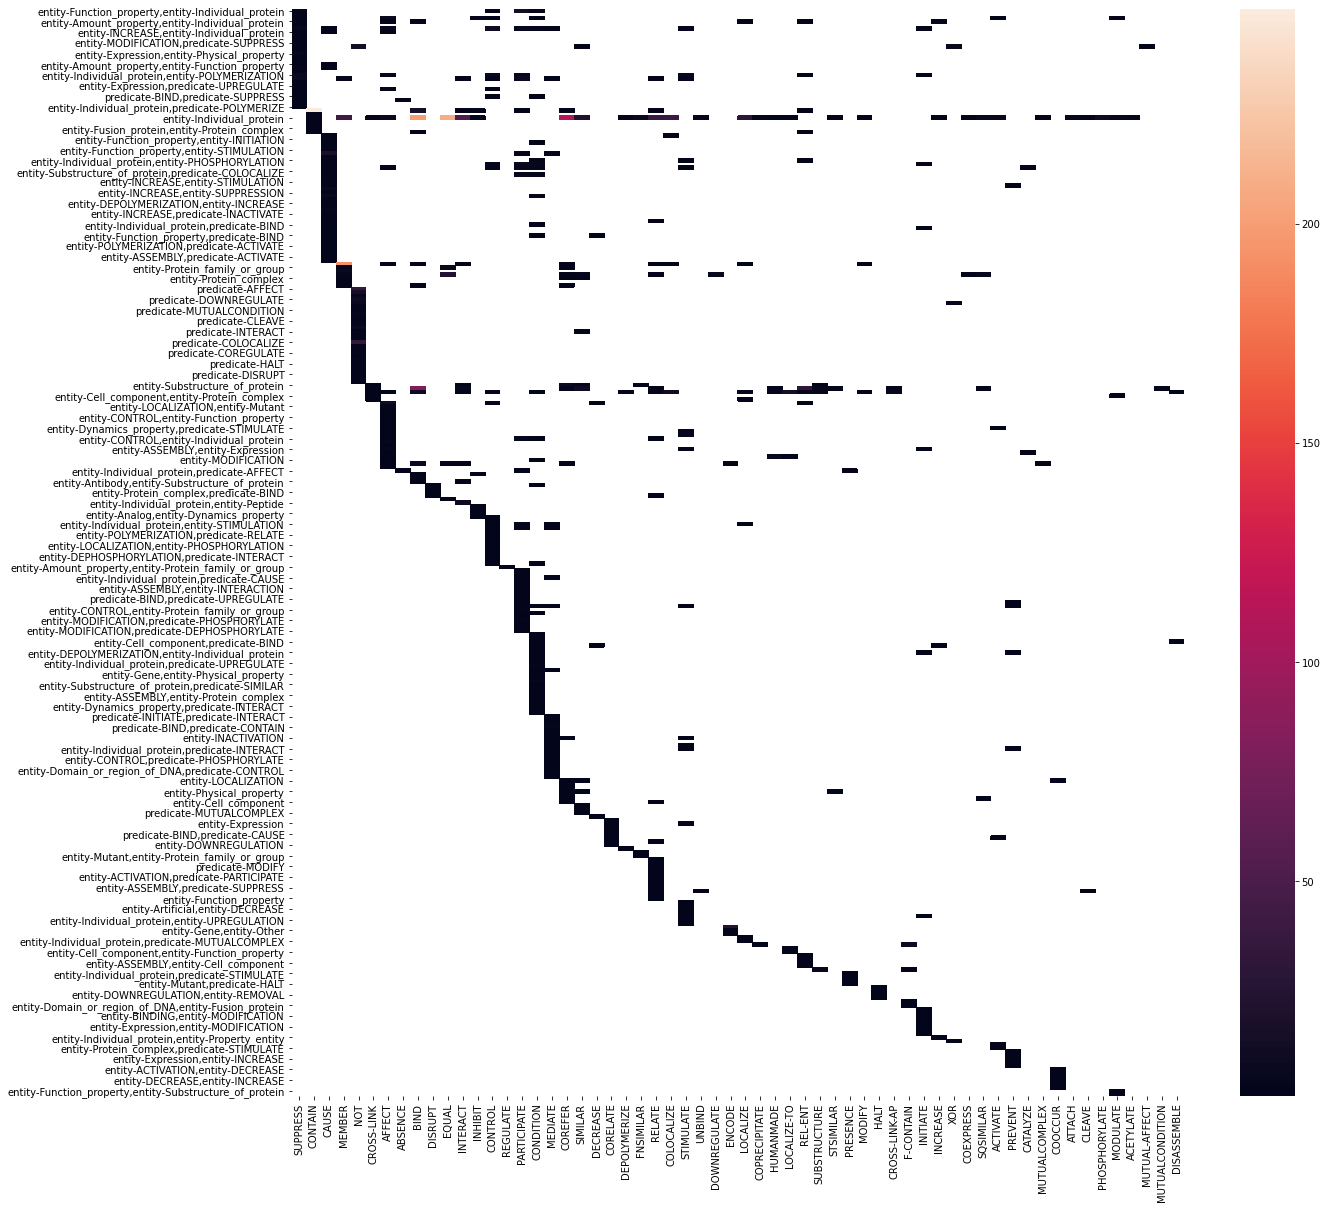

In [131]:
ax, fig = plt.subplots(1,figsize=(20,20))
sns.heatmap(config_df)

How many relations are in the data?

In [133]:
configuration

{'SUPPRESS': Counter({'entity-Function_property,entity-Individual_protein': 3,
          'entity-Function_property,predicate-PREVENT': 2,
          'entity-Dynamics_property,entity-Individual_protein': 1,
          'entity-Amount_property,entity-Individual_protein': 1,
          'entity-MODIFICATION,predicate-LOCALIZE-TO': 2,
          'entity-ASSEMBLY,entity-Individual_protein': 5,
          'entity-INCREASE,entity-Individual_protein': 3,
          'entity-DEPOLYMERIZATION,entity-Mutant': 1,
          'entity-DEPOLYMERIZATION,predicate-INHIBIT': 2,
          'entity-MODIFICATION,predicate-SUPPRESS': 1,
          'predicate-BIND': 2,
          'entity-Function_property,entity-INACTIVATION': 1,
          'entity-Expression,entity-Physical_property': 4,
          'entity-Amount_property,entity-Property_entity': 1,
          'entity-Amount_property,entity-Dynamics_property': 1,
          'entity-Amount_property,entity-Function_property': 2,
          'entity-DECREASE,entity-Individual_pro

In [164]:
configuration

{'SUPPRESS': Counter({'entity-Function_property,entity-Individual_protein': 3,
          'entity-Function_property,predicate-PREVENT': 2,
          'entity-Dynamics_property,entity-Individual_protein': 1,
          'entity-Amount_property,entity-Individual_protein': 1,
          'entity-MODIFICATION,predicate-LOCALIZE-TO': 2,
          'entity-ASSEMBLY,entity-Individual_protein': 5,
          'entity-INCREASE,entity-Individual_protein': 3,
          'entity-DEPOLYMERIZATION,entity-Mutant': 1,
          'entity-DEPOLYMERIZATION,predicate-INHIBIT': 2,
          'entity-MODIFICATION,predicate-SUPPRESS': 1,
          'predicate-BIND': 2,
          'entity-Function_property,entity-INACTIVATION': 1,
          'entity-Expression,entity-Physical_property': 4,
          'entity-Amount_property,entity-Property_entity': 1,
          'entity-Amount_property,entity-Dynamics_property': 1,
          'entity-Amount_property,entity-Function_property': 2,
          'entity-DECREASE,entity-Individual_pro

In [135]:
configuration

{'SUPPRESS': Counter({'entity-Function_property,entity-Individual_protein': 3,
          'entity-Function_property,predicate-PREVENT': 2,
          'entity-Dynamics_property,entity-Individual_protein': 1,
          'entity-Amount_property,entity-Individual_protein': 1,
          'entity-MODIFICATION,predicate-LOCALIZE-TO': 2,
          'entity-ASSEMBLY,entity-Individual_protein': 5,
          'entity-INCREASE,entity-Individual_protein': 3,
          'entity-DEPOLYMERIZATION,entity-Mutant': 1,
          'entity-DEPOLYMERIZATION,predicate-INHIBIT': 2,
          'entity-MODIFICATION,predicate-SUPPRESS': 1,
          'predicate-BIND': 2,
          'entity-Function_property,entity-INACTIVATION': 1,
          'entity-Expression,entity-Physical_property': 4,
          'entity-Amount_property,entity-Property_entity': 1,
          'entity-Amount_property,entity-Dynamics_property': 1,
          'entity-Amount_property,entity-Function_property': 2,
          'entity-DECREASE,entity-Individual_pro

How many relation predicates?

In [ ]:
len(relation_types)

relation_types = config_df.sum().sort_values(ascending=False)

relation_types.sum() * 0.9


relation_types.head(10).sum() / relation_types.sum()

relation_types

<AxesSubplot:>

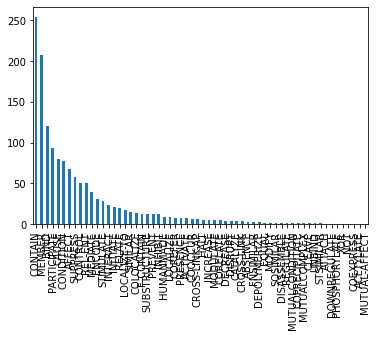

In [89]:
relation_types.plot.bar()

In [34]:
f.rootNode.predicate.name

'SUPPRESS'

In [25]:
a = f.rootNode.arguments[0]

In [27]:
a.isEntity()

True

In [29]:
a.entity.type.name

'Individual_protein'

In [18]:
f.rootNode.predicate.name

'CATALYZE'

#### inspect results

In [6]:
texts[0]

['alpha-catenin',
 'inhibits',
 'beta-catenin',
 'signaling',
 'by',
 'preventing',
 'formation',
 'of',
 'a',
 'beta-catenin*T-cell',
 'factor*DNA',
 'complex',
 '.']

In [7]:
tuple_labels[0]

[('Individual_protein', (2,)),
 ('Individual_protein', (9,)),
 ('Individual_protein', (9, 10)),
 ('Individual_protein', (0,)),
 ('Function_property', (2, 3)),
 ('Protein_complex', (9, 9, 9, 10, 10, 11))]

In [8]:
BIO_labels[0]

['B-Individual_protein',
 'O',
 'B-Function_property',
 'I-Function_property',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-Protein_complex',
 'I-Protein_complex',
 'I-Protein_complex',
 'O']

In [9]:
# training_sentences, test_sentences = get_sentences(0.2)

# vocab_dict = eval(open('vocab_dict.txt', 'r').read())
# vector_dim = 256  # from page 6 of the paper

# the_model = Model(vocab_dict, vector_dim, vector_dim)
# print(the_model.forward(training_sentences[0]))  # example usage

In [10]:
from collections import namedtuple

from dgl.data.tree import SSTDataset


SSTBatch = namedtuple('SSTBatch', ['graph', 'mask', 'wordid', 'label'])

# Each sample in the dataset is a constituency tree. The leaf nodes
# represent words. The word is an int value stored in the "x" field.
# The non-leaf nodes have a special word PAD_WORD. The sentiment
# label is stored in the "y" feature field.
trainset = SSTDataset(mode='tiny')  # the "tiny" set has only five trees
tiny_sst = trainset.trees
num_vocabs = trainset.num_vocabs
num_classes = trainset.num_classes

vocab = trainset.vocab # vocabulary dict: key -> id
inv_vocab = {v: k for k, v in vocab.items()} # inverted vocabulary dict: id -> word

a_tree = tiny_sst[0]
for token in a_tree.ndata['x'].tolist():
    if token != trainset.PAD_WORD:
        print(inv_vocab[token], end=" ")

the rock is destined to be the 21st century 's new `` conan '' and that he 's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal . 

/Users/gabe/opt/miniconda3/envs/289G_NLP/lib/python3.8/site-packages/dgl/data/utils.py:285: UserWarning: Property dataset.trees will be deprecated, please use [dataset[i] for i in len(dataset)] instead.
  warnings.warn('Property {} will be deprecated, please use {} instead.'.format(old, new))
/Users/gabe/opt/miniconda3/envs/289G_NLP/lib/python3.8/site-packages/dgl/data/utils.py:285: UserWarning: Property dataset.num_vocabs will be deprecated, please use dataset.vocab_size instead.
  warnings.warn('Property {} will be deprecated, please use {} instead.'.format(old, new))


In [11]:
class TreeLSTMCell(nn.Module):
    def __init__(self, x_size, h_size):
        super(TreeLSTMCell, self).__init__()
#         self.W_i
#         self.W_f
#         self.W_o
        self.W_iou = nn.Linear(x_size, 3 * h_size, bias=False)
        self.U_iou = nn.Linear(2 * h_size, 3 * h_size, bias=False)
        self.b_iou = nn.Parameter(th.zeros(1, 3 * h_size))
        self.U_f = nn.Linear(2 * h_size, 2 * h_size)

    def message_func(self, edges):
        return {'h': edges.src['h'], 'c': edges.src['c']}

    def reduce_func(self, nodes):
        # concatenate h_jl for equation (1), (2), (3), (4)
        h_cat = nodes.mailbox['h'].view(nodes.mailbox['h'].size(0), -1)
        # equation (2)
        f = th.sigmoid(self.U_f(h_cat)).view(*nodes.mailbox['h'].size())
        # second term of equation (5)
        c = th.sum(f * nodes.mailbox['c'], 1)
        return {'iou': self.U_iou(h_cat), 'c': c}

    def apply_node_func(self, nodes):
        # equation (1), (3), (4)
        iou = nodes.data['iou'] + self.b_iou
        i, o, u = th.chunk(iou, 3, 1)
        i, o, u = th.sigmoid(i), th.sigmoid(o), th.tanh(u)
        # equation (5)
        c = i * u + nodes.data['c']
        # equation (6)
        h = o * th.tanh(c)
        return {'h' : h, 'c' : c}


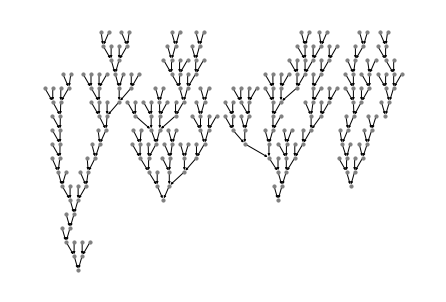

In [12]:
import networkx as nx
import matplotlib.pyplot as plt

graph = dgl.batch(tiny_sst)
def plot_tree(g):
    # this plot requires pygraphviz package
    pos = nx.nx_agraph.graphviz_layout(g, prog='dot')
    nx.draw(g, pos, with_labels=False, node_size=10,
            node_color=[[.5, .5, .5]], arrowsize=4)
    plt.show()

plot_tree(graph.to_networkx())


In [13]:
import dgl.function as fn

In [14]:
class TreeLSTM(nn.Module):
    def __init__(self,
                 num_vocabs,
                 x_size,
                 h_size,
                 num_classes,
                 dropout,
                 pretrained_emb=None):
        super(TreeLSTM, self).__init__()
        self.x_size = x_size
        self.embedding = nn.Embedding(num_vocabs, x_size)
        if pretrained_emb is not None:
            print('Using glove')
            self.embedding.weight.data.copy_(pretrained_emb)
            self.embedding.weight.requires_grad = True
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(h_size, num_classes)
        self.cell = TreeLSTMCell(x_size, h_size)

    def forward(self, batch, h, c):
        """Compute tree-lstm prediction given a batch.

        Parameters
        ----------
        batch : dgl.data.SSTBatch
            The data batch.
        h : Tensor
            Initial hidden state.
        c : Tensor
            Initial cell state.

        Returns
        -------
        logits : Tensor
            The prediction of each node.
        """
        g = batch.graph
        # to heterogenous graph
        g = dgl.graph(g.edges())
        # feed embedding
        embeds = self.embedding(batch.wordid * batch.mask)
        g.ndata['iou'] = self.cell.W_iou(self.dropout(embeds)) * batch.mask.float().unsqueeze(-1)
        g.ndata['h'] = h
        g.ndata['c'] = c
        # propagate
        dgl.prop_nodes_topo(g,
                            message_func=self.cell.message_func,
                            reduce_func=self.cell.reduce_func,
                            apply_node_func=self.cell.apply_node_func)
        # compute logits
        h = self.dropout(g.ndata.pop('h'))
        logits = self.linear(h)
        return logits

In [15]:
from torch.utils.data import DataLoader
import torch.nn.functional as F

device = th.device('cpu')
# hyper parameters
x_size = 256
h_size = 256
dropout = 0.5
lr = 0.05
weight_decay = 1e-4
epochs = 10

# create the model
model = TreeLSTM(trainset.num_vocabs,
                 x_size,
                 h_size,
                 trainset.num_classes,
                 dropout)
print(model)

# create the optimizer
optimizer = th.optim.Adagrad(model.parameters(),
                          lr=lr,
                          weight_decay=weight_decay)

# def batcher(dev):
def batcher_dev(batch):
    batch_trees = dgl.batch(batch)
    return SSTBatch(graph=batch_trees,
                    mask=batch_trees.ndata['mask'].to(device),
                    wordid=batch_trees.ndata['x'].to(device),
                    label=batch_trees.ndata['y'].to(device))
#     return batcher_dev

train_loader = DataLoader(dataset=tiny_sst,
                          batch_size=5,
                          collate_fn=batcher_dev,
                          shuffle=False,
                          num_workers=2)

# training loop
for epoch in range(epochs):
    for step, batch in enumerate(train_loader):
        g = batch.graph
        n = g.number_of_nodes()
        h = th.zeros((n, h_size))
        c = th.zeros((n, h_size))
        logits = model(batch, h, c)
        logp = F.log_softmax(logits, 1)
        loss = F.nll_loss(logp, batch.label, reduction='sum')
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pred = th.argmax(logits, 1)
        acc = float(th.sum(th.eq(batch.label, pred))) / len(batch.label)
        print("Epoch {:05d} | Step {:05d} | Loss {:.4f} | Acc {:.4f} |".format(
            epoch, step, loss.item(), acc))

TreeLSTM(
  (embedding): Embedding(19536, 256)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=256, out_features=5, bias=True)
  (cell): TreeLSTMCell(
    (W_iou): Linear(in_features=256, out_features=768, bias=False)
    (U_iou): Linear(in_features=512, out_features=768, bias=False)
    (U_f): Linear(in_features=512, out_features=512, bias=True)
  )
)


/Users/gabe/opt/miniconda3/envs/289G_NLP/lib/python3.8/site-packages/dgl/data/utils.py:285: UserWarning: Property dataset.num_vocabs will be deprecated, please use dataset.vocab_size instead.
  warnings.warn('Property {} will be deprecated, please use {} instead.'.format(old, new))


RuntimeError: DataLoader worker (pid(s) 5271) exited unexpectedly